In [1]:
pip install tensorflow-macos==2.15 tensorflow-metal pandas numpy kaggle seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import numpy as np
import pandas as pd

import json
import random

import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras as K

import matplotlib.pyplot as plt

# plotting style
plt.style.use("ggplot")

In [3]:
# Config for DS
DS_PATH = "../ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"


# Config for img processing
CHANNELS = 3
IMG_RES = 128
IMG_COUNT_PER_CLASS = 200
VALID_IMG_EXT = [".jpg", ".jpeg", ".png", ".bmp"]


# Config for model training
N_EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 64

## Carga del Dataset


In [4]:
# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


In [5]:
def resize_and_pad_image(image, img_size):
    # Check for images with transparency and add a white background if needed
    if image.mode in ("RGBA", "LA"):
        # Create a white background image (255, 255, 255 = white)
        white_background = Image.new("RGB", image.size, (255, 255, 255))
        # Paste the RGBA image onto the white background, using the alpha channel as a mask
        white_background.paste(image, (0, 0), mask=image)
        image = white_background  # Update image to have a white background

    original_width, original_height = image.size
    aspect_ratio = original_width / original_height

    # Calculate new dimensions based on aspect ratio
    if original_width > original_height:
        new_width = img_size[0]
        new_height = int(img_size[0] / aspect_ratio)
    else:
        new_height = img_size[1]
        new_width = int(img_size[1] * aspect_ratio)

    # Resize the image with high-quality downsampling
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new blank image with the target size (white padding)
    padded_image = Image.new("RGB", img_size, (255, 255, 255))

    # Calculate position to paste the resized image onto the padded image
    x_offset = (img_size[0] - resized_image.size[0]) // 2
    y_offset = (img_size[1] - resized_image.size[1]) // 2

    # Paste the resized image onto the padded image
    padded_image.paste(resized_image, (x_offset, y_offset))

    return padded_image

In [6]:
# import cv2
from pathlib import Path

X = []
y = []
labelNames = {}


print("[INFO]: Leyendo imagenes de poses")
for id, pose in enumerate(df.itertuples()):
    print(f"[INFO]: Procesando pose: {pose.sanskrit_name} / {pose.english_name}")
    labelNames[id] = pose.english_name

    # Obtengo la carpeta de imagenes de la pose
    folder = f"{DS_PATH}/{pose.sanskrit_name}"

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        if Path(img_path).suffix.lower() not in VALID_IMG_EXT:
            print(f"[WARN]: Formato {img_path} no valido")
            continue

        img = Image.open(img_path)

        img = resize_and_pad_image(img, (IMG_RES, IMG_RES))

        X.append(img)
        y.append(id)


# Convertir a numpy array
X = np.array(X)
y = np.array(y)

[INFO]: Leyendo imagenes de poses
[INFO]: Procesando pose: Navasana / Boat
[INFO]: Procesando pose: Ardha Navasana / Half-Boat
[INFO]: Procesando pose: Dhanurasana / Bow
[INFO]: Procesando pose: Setu Bandha Sarvangasana / Bridge
[INFO]: Procesando pose: Baddha Konasana / Butterfly
[INFO]: Procesando pose: Ustrasana / Camel
[INFO]: Procesando pose: Marjaryasana / Cat
[INFO]: Procesando pose: Bitilasana / Cow
[INFO]: Procesando pose: Utkatasana / Chair
[INFO]: Procesando pose: Balasana / Child's Pose


/Users/emanuel.suriano/Git/deep-learning-group-7/.venv/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO]: Procesando pose: Sivasana / Corpse
[INFO]: Procesando pose: Alanasana / Crescent Lunge
[INFO]: Procesando pose: Bakasana / Crow
[INFO]: Procesando pose: Ardha Pincha Mayurasana / Dolphin
[INFO]: Procesando pose: Adho Mukha Svanasana / Downward-Facing Dog
[INFO]: Procesando pose: Garudasana / Eagle
[INFO]: Procesando pose: Utthita Hasta Padangusthasana / Extended Hand to Toe
[INFO]: Procesando pose: Utthita Parsvakonasana / Extended Side Angle
[INFO]: Procesando pose: Pincha Mayurasana / Forearm Stand
[INFO]: Procesando pose: Uttanasana / Forward Bend with Shoulder Opener
[INFO]: Procesando pose: Ardha Chandrasana / Half-Moon
[INFO]: Procesando pose: Adho Mukha Vrksasana / Handstand
[INFO]: Procesando pose: Anjaneyasana / Low Lunge
[INFO]: Procesando pose: Supta Kapotasana / Pigeon
[INFO]: Procesando pose: Eka Pada Rajakapotasana / King Pigeon
[INFO]: Procesando pose: Phalakasana / Plank
[INFO]: Procesando pose: Halasana / Plow
[INFO]: Procesando pose: Parsvottanasana / Pyramid


## Sample Preview


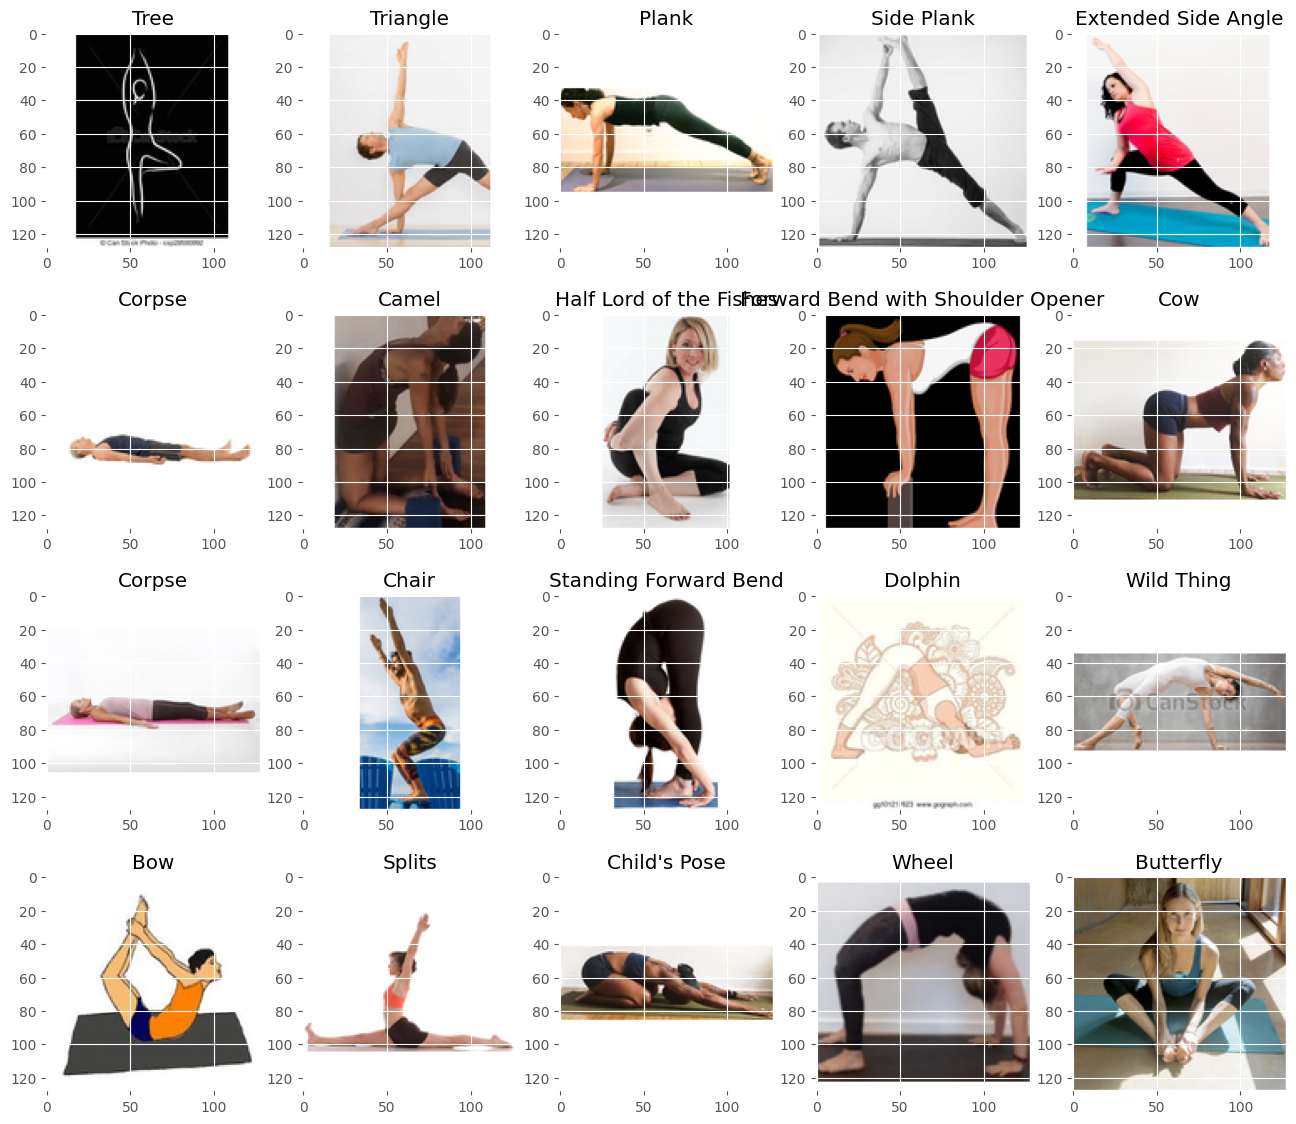

In [7]:
fig = plt.figure(figsize=(16, 14))

samples = np.random.randint(0, len(X), 20)

for i, img_idx in enumerate(samples):
    fig.add_subplot(4, 5, i + 1)

    plt.imshow(X[img_idx])
    plt.title(labelNames[y[img_idx]])

plt.show()

## Data Augmentation


In [8]:
datagen = K.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,  # 20% for validation
    # Augmentations (applied only to training subset)
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.8, 1.2),
)

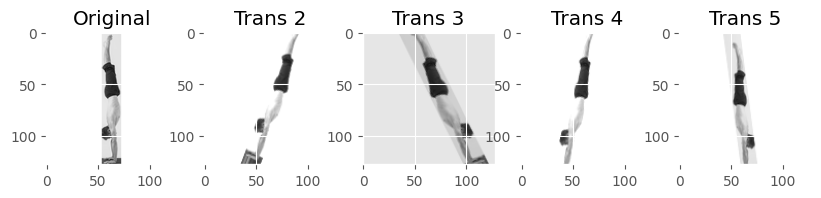

In [9]:
sample = random.randint(0, len(X))

img_orig = X[sample]

fig = plt.figure(figsize=(16, 10))

fig.add_subplot(4, 8, 1)
plt.imshow(img_orig)
plt.title("Original")

# # Show transformations
for n in range(2, 6):
    fig.add_subplot(4, 8, n)
    img = datagen.random_transform(img_orig)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Trans {n}")

plt.show()

## Analisis de la distribucion


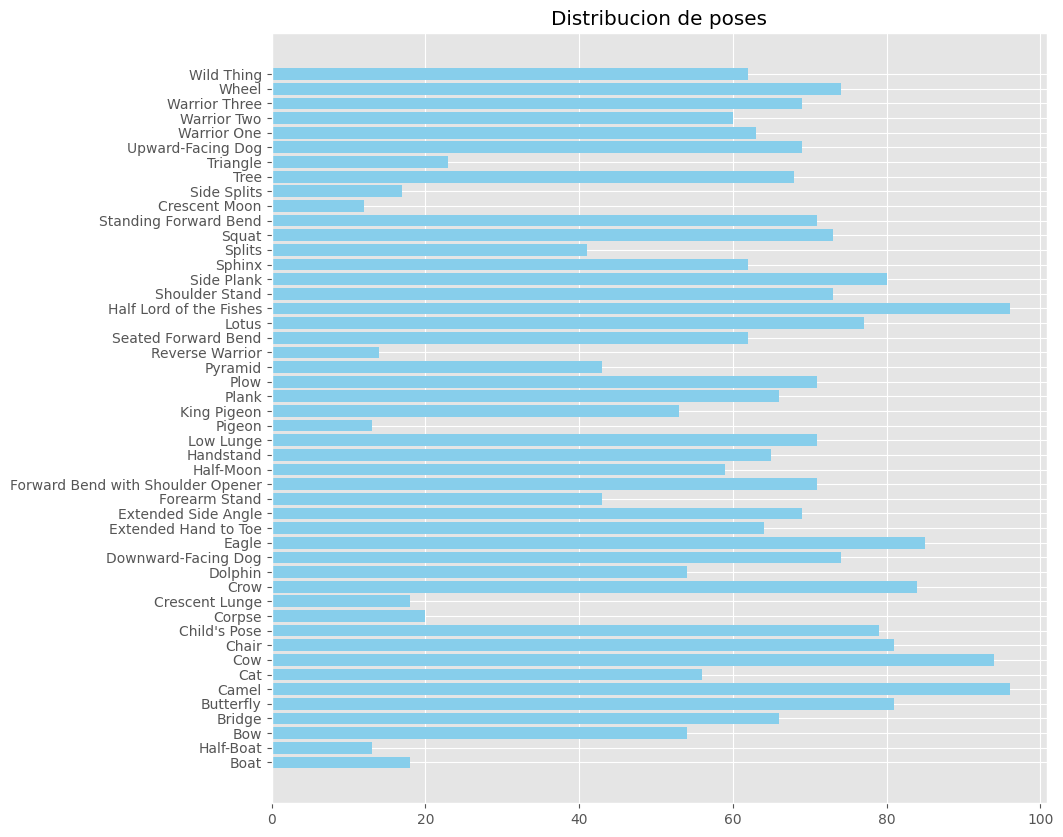

In [10]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(labelNames.values(), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

## Balanceo de clases - Oversampling


In [11]:
for label in np.unique(y):
    X_filtered = X[y == label]
    num_augmentations = IMG_COUNT_PER_CLASS - len(X_filtered)

    if num_augmentations > 0:
        print(f"[INFO]: Nuevas {num_augmentations} poses de {labelNames[label]}")
        img_random_order = np.random.permutation(X_filtered)

        X_aug = [
            datagen.random_transform(img_random_order[i % len(X_filtered)]).astype(
                np.uint8
            )
            for i in range(num_augmentations)
        ]

        y_aug = [label] * num_augmentations

        X = np.append(X, np.array(X_aug), axis=0)
        y = np.append(y, np.array(y_aug), axis=0)

[INFO]: Nuevas 182 poses de Boat
[INFO]: Nuevas 187 poses de Half-Boat
[INFO]: Nuevas 146 poses de Bow
[INFO]: Nuevas 134 poses de Bridge
[INFO]: Nuevas 119 poses de Butterfly
[INFO]: Nuevas 104 poses de Camel
[INFO]: Nuevas 144 poses de Cat
[INFO]: Nuevas 106 poses de Cow
[INFO]: Nuevas 119 poses de Chair
[INFO]: Nuevas 121 poses de Child's Pose
[INFO]: Nuevas 180 poses de Corpse
[INFO]: Nuevas 182 poses de Crescent Lunge
[INFO]: Nuevas 116 poses de Crow
[INFO]: Nuevas 146 poses de Dolphin
[INFO]: Nuevas 126 poses de Downward-Facing Dog
[INFO]: Nuevas 115 poses de Eagle
[INFO]: Nuevas 136 poses de Extended Hand to Toe
[INFO]: Nuevas 131 poses de Extended Side Angle
[INFO]: Nuevas 157 poses de Forearm Stand
[INFO]: Nuevas 129 poses de Forward Bend with Shoulder Opener
[INFO]: Nuevas 141 poses de Half-Moon
[INFO]: Nuevas 135 poses de Handstand
[INFO]: Nuevas 129 poses de Low Lunge
[INFO]: Nuevas 187 poses de Pigeon
[INFO]: Nuevas 147 poses de King Pigeon
[INFO]: Nuevas 134 poses de Plan

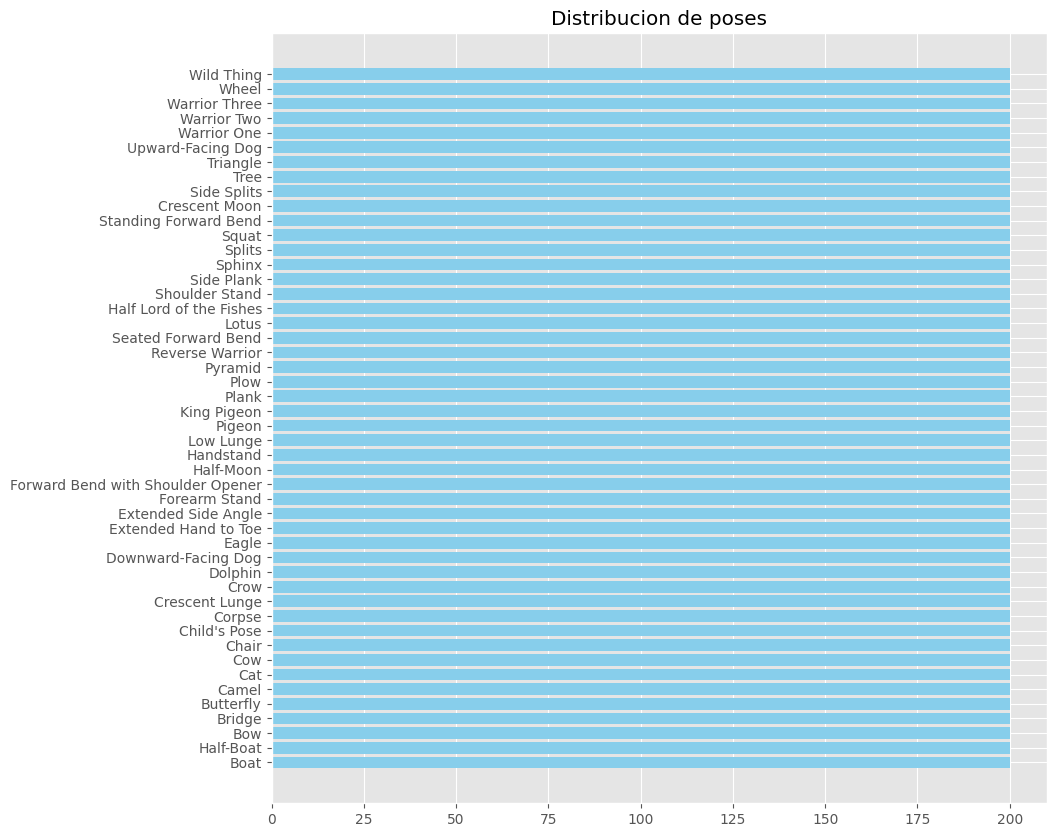

In [12]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(labelNames.values(), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Output the results
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Check the class distribution
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

X_train: (6720, 128, 128, 3)
y_train: (6720,)
X_test: (2880, 128, 128, 3)
y_test: (2880,)
Class distribution in y_train: [140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140
 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140
 140 140 140 140 140 140 140 140 140 140 140 140]
Class distribution in y_test: [60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60
 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60]


## Normalization


In [14]:
from sklearn.preprocessing import LabelBinarizer

# One hot encoding for labels
lb = LabelBinarizer()
y_train_n = lb.fit_transform(y_train)
y_test_n = lb.transform(y_test)

## Model definition

> Reemplazar esto por el modelo que quieran entrenar! ⚠️

Este es un ejemplo de un modelo pre-entrenado en modo forward (no hay capas adicionales).


In [18]:
input_shape = (IMG_RES, IMG_RES, CHANNELS)
n_classes = len(labelNames)

# Pre-trained
base_model = K.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# transfer-learning mode
base_model.trainable = False

model_layers = [
    K.layers.Input(shape=input_shape),
    base_model,
    K.layers.GlobalAveragePooling2D(),
    K.layers.Dense(n_classes, activation="softmax"),
]

model = K.models.Sequential(model_layers)

model.compile(
    loss="categorical_crossentropy",
    # For mac users
    optimizer=K.optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
    ),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 48)                24624     
                                                                 
Total params: 14739312 (56.23 MB)
Trainable params: 24624 (96.19 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
val_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Early stopping in case it stops converging
early_stopping = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    mode="min",
    restore_best_weights=True,
)

# Use datageneration for training and validation data
train_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="training",
)

validation_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="validation",
)


# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=N_EPOCHS,
    callbacks=[early_stopping],
)

[INFO]: Entrenando la red...
Epoch 1/100
84/84 [==============================] - 15s 169ms/step - loss: 3.9728 - accuracy: 0.0206 - val_loss: 3.8792 - val_accuracy: 0.0268
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 3.8627 - accuracy: 0.0257

In [143]:
from sklearn.metrics import classification_report

# X_test no tuvo normalizacion
X_test_n = X_test / 255

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=BATCH_SIZE)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
45/45 [==============================] - 6s 129ms/step
                                   precision    recall  f1-score   support

                             Boat       0.96      0.92      0.94        60
                        Half-Boat       0.67      0.88      0.76        60
                              Bow       0.74      0.85      0.79        60
                           Bridge       0.87      0.80      0.83        60
                        Butterfly       0.49      0.55      0.52        60
                            Camel       0.66      0.85      0.74        60
                              Cat       0.65      0.67      0.66        60
                              Cow       0.68      0.72      0.70        60
                            Chair       0.65      0.67      0.66        60
                     Child's Pose       0.69      0.57      0.62        60
                           Corpse       0.89      0.92      0.90        60
             

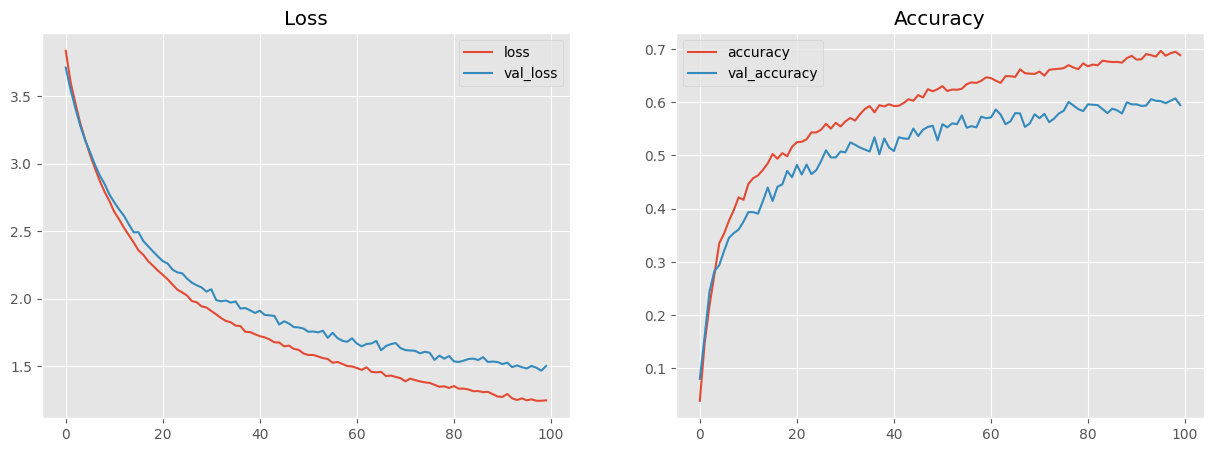

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()